In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K  # Для создания пользовательской метрики
import category_encoders as ce

In [2]:
# Load datasets
train_df = pd.read_csv('d://ml///playground//train.csv')
test_df = pd.read_csv('d://ml///playground//test.csv')
test_ids = test_df['id']

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [4]:
def print_nan(df):
    # выбираем не нулевые значения
    missing_values = df.isnull().sum() / len(df) * 100
    non_zero_missing_values = missing_values[missing_values > 0]
    missing_values_df = non_zero_missing_values.reset_index()
    missing_values_df.columns = ['Column', 'Percentage']
    # Визуализация пропущенных значений
    plt.figure(figsize=(15, 2))
    ax = sns.barplot(x='Column', y='Percentage', data=missing_values_df, hue = 'Column')
    sns.color_palette("hls", 8)
    plt.title('Пропущенные значения')
    plt.ylabel('Проценты (%)')
    plt.xlabel('Пропуски в данных')
    plt.ylim(0, 40)
    for i in range (len(missing_values_df)):
        ax.bar_label(ax.containers[i])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

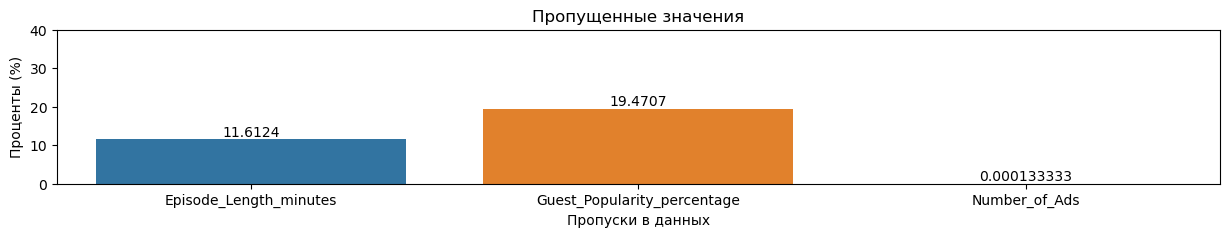

In [5]:
print_nan(train_df)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

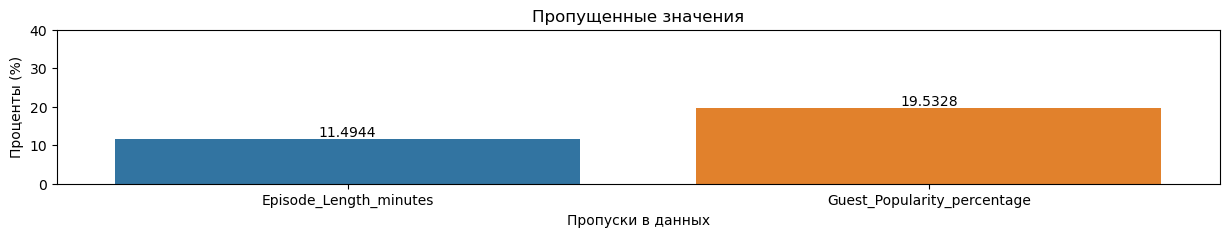

In [6]:
print_nan(test_df)

### EDA

In [7]:
# работаем с тренировачной базой
data = train_df.copy()

In [8]:
# Заполнение пропущенных значений в Number_of_Ads медианой
median_number_of_ads = data['Number_of_Ads'].median()
data['Number_of_Ads'].fillna(median_number_of_ads, inplace=True)

In [9]:
# Создание бинарного признака "Наличие гостя"
data['Guest'] = data['Guest_Popularity_percentage'].notnull().astype(float)

print("\nБинарный признак 'Наличие гостя' создан:")
print(data['Guest'].value_counts())
data.drop(columns=['Guest_Popularity_percentage'], inplace=True)


Бинарный признак 'Наличие гостя' создан:
1.0    603970
0.0    146030
Name: Guest, dtype: int64


In [10]:
# Delete cols
#train_df.drop(columns=['id', 'Episode_Title'], inplace=True, errors='ignore')
#test_df.drop(columns=['id', 'Episode_Title'], inplace=True, errors='ignore')

In [11]:
# Прогноз Episode_Length_minutes на основе существующих признаков 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

In [12]:
# 1. Разделение данных на тренировочную и тестовую выборки
# Тренировочные данные: строки с непустыми Episode_Length_minutes
train_data = data[data['Episode_Length_minutes'].notnull()]
# Данные для предсказания: строки с пропущенными Episode_Length_minutes
predict_data = data[data['Episode_Length_minutes'].isnull()]
print("\nРазделение данных завершено:")
print(f"- Количество строк для обучения модели: {train_data.shape[0]}")
print(f"- Количество строк для предсказания: {predict_data.shape[0]}")


Разделение данных завершено:
- Количество строк для обучения модели: 662907
- Количество строк для предсказания: 87093


In [13]:
# 2. Выбор признаков
# Числовые признаки
numeric_features = ['Host_Popularity_percentage', 'Guest', 'Number_of_Ads', 'Listening_Time_minutes']

# Категориальные признаки
categorical_features = ['Genre', 'Publication_Day', 'Episode_Sentiment']

# Создание общей матрицы признаков
X_train_numeric = train_data[numeric_features]
X_predict_numeric = predict_data[numeric_features]

# One-Hot-Encoding для категориальных признаков
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical = encoder.fit_transform(train_data[categorical_features])
X_predict_categorical = encoder.transform(predict_data[categorical_features])

# Объединение числовых и закодированных категориальных признаков
X_train = np.hstack([X_train_numeric, X_train_categorical.toarray()])
X_predict = np.hstack([X_predict_numeric, X_predict_categorical.toarray()])

# Целевая переменная
y_train = train_data['Episode_Length_minutes']

print("\nПризнаки успешно подготовлены:")
print(f"- Размерность тренировочных данных: {X_train.shape}")
print(f"- Размерность данных для предсказания: {X_predict.shape}")


Признаки успешно подготовлены:
- Размерность тренировочных данных: (662907, 24)
- Размерность данных для предсказания: (87093, 24)


In [14]:
# 3. Разделение на обучающую и валидационную выборки для оценки модели
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print("\nРазделение на обучающую и валидационную выборки завершено:")
print(f"- Размер обучающей выборки: {X_train_split.shape[0]}")
print(f"- Размер валидационной выборки: {X_val_split.shape[0]}")


Разделение на обучающую и валидационную выборки завершено:
- Размер обучающей выборки: 530325
- Размер валидационной выборки: 132582


In [15]:
# 4. Обучение модели
model = RandomForestRegressor(random_state=42, n_estimators=100, verbose=1, n_jobs=-1)
print("\nНачало обучения модели...")
model.fit(X_train_split, y_train_split)
print("Обучение модели завершено.")


Начало обучения модели...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   35.1s


Обучение модели завершено.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished


In [16]:
# 5. Оценка качества модели на валидационной выборке
from sklearn.metrics import mean_absolute_error
y_val_pred = model.predict(X_val_split)
mae = mean_absolute_error(y_val_split, y_val_pred)
print(f"\nОценка качества модели (MAE): {mae:.2f}")

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.8s



Оценка качества модели (MAE): 7.96


[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    4.2s finished


In [17]:
# 6. Предсказание пропущенных значений
print("\nНачало предсказания пропущенных значений...")
predicted_values = model.predict(X_predict)
print("Предсказание завершено.")

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.



Начало предсказания пропущенных значений...


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.2s


Предсказание завершено.


[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    2.3s finished


In [18]:
# 7. Заполнение пропущенных значений в исходном DataFrame
data.loc[data['Episode_Length_minutes'].isnull(), 'Episode_Length_minutes'] = predicted_values

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          750000 non-null  int64  
 1   Podcast_Name                750000 non-null  object 
 2   Episode_Title               750000 non-null  object 
 3   Episode_Length_minutes      750000 non-null  float64
 4   Genre                       750000 non-null  object 
 5   Host_Popularity_percentage  750000 non-null  float64
 6   Publication_Day             750000 non-null  object 
 7   Publication_Time            750000 non-null  object 
 8   Number_of_Ads               750000 non-null  float64
 9   Episode_Sentiment           750000 non-null  object 
 10  Listening_Time_minutes      750000 non-null  float64
 11  Guest                       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [22]:
# создаем временную точку восстановления
data_temp = data.copy()

In [ ]:
stop

In [23]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          750000 non-null  int64  
 1   Podcast_Name                750000 non-null  object 
 2   Episode_Title               750000 non-null  object 
 3   Episode_Length_minutes      750000 non-null  float64
 4   Genre                       750000 non-null  object 
 5   Host_Popularity_percentage  750000 non-null  float64
 6   Publication_Day             750000 non-null  object 
 7   Publication_Time            750000 non-null  object 
 8   Number_of_Ads               750000 non-null  float64
 9   Episode_Sentiment           750000 non-null  object 
 10  Listening_Time_minutes      750000 non-null  float64
 11  Guest                       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [24]:
# разбираемся с test_df
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           250000 non-null  int64  
 1   Podcast_Name                 250000 non-null  object 
 2   Episode_Title                250000 non-null  object 
 3   Episode_Length_minutes       221264 non-null  float64
 4   Genre                        250000 non-null  object 
 5   Host_Popularity_percentage   250000 non-null  float64
 6   Publication_Day              250000 non-null  object 
 7   Publication_Time             250000 non-null  object 
 8   Guest_Popularity_percentage  201168 non-null  float64
 9   Number_of_Ads                250000 non-null  float64
 10  Episode_Sentiment            250000 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 21.0+ MB


In [25]:
# Создание бинарного признака "Наличие гостя"
test_df['Guest'] = test_df['Guest_Popularity_percentage'].notnull().astype(float)

print("\nБинарный признак 'Наличие гостя' создан:")
print(test_df['Guest'].value_counts())
test_df.drop(columns=['Guest_Popularity_percentage'], inplace=True)
test_df.info()


Бинарный признак 'Наличие гостя' создан:
1.0    201168
0.0     48832
Name: Guest, dtype: int64


KeyError: "['Guest_Popularity_percentage'] not found in axis"

In [27]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          250000 non-null  int64  
 1   Podcast_Name                250000 non-null  object 
 2   Episode_Title               250000 non-null  object 
 3   Episode_Length_minutes      221264 non-null  float64
 4   Genre                       250000 non-null  object 
 5   Host_Popularity_percentage  250000 non-null  float64
 6   Publication_Day             250000 non-null  object 
 7   Publication_Time            250000 non-null  object 
 8   Number_of_Ads               250000 non-null  float64
 9   Episode_Sentiment           250000 non-null  object 
 10  Guest                       250000 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 21.0+ MB


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          750000 non-null  int64  
 1   Podcast_Name                750000 non-null  object 
 2   Episode_Title               750000 non-null  object 
 3   Episode_Length_minutes      750000 non-null  float64
 4   Genre                       750000 non-null  object 
 5   Host_Popularity_percentage  750000 non-null  float64
 6   Publication_Day             750000 non-null  object 
 7   Publication_Time            750000 non-null  object 
 8   Number_of_Ads               750000 non-null  float64
 9   Episode_Sentiment           750000 non-null  object 
 10  Listening_Time_minutes      750000 non-null  float64
 11  Guest                       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [ ]:
# нужно разобраться с Episode_Length_minutes. Заполним 

In [37]:
from sklearn.impute import KNNImputer

In [42]:
# 1. Выбор признаков
numeric_features = [
    'Host_Popularity_percentage', 'Guest', 'Number_of_Ads'
]
categorical_features = ['Genre', 'Publication_Day', 'Episode_Sentiment']

# Числовые признаки
X_numeric = test_df[numeric_features]

# Категориальные признаки (One-Hot-Encoding)
encoder = OneHotEncoder(handle_unknown='ignore')
X_categorical = encoder.fit_transform(test_df[categorical_features])

# Объединение числовых и закодированных категориальных признаков
X = np.hstack([X_numeric, X_categorical.toarray()])

# Добавление целевой переменной (Episode_Length_minutes) в данные
y = test_df['Episode_Length_minutes'].values.reshape(-1, 1)
X_with_target = np.hstack([X, y])
print("\nПризнаки успешно подготовлены:")
print(f"- Размерность данных: {X_with_target.shape}")


Признаки успешно подготовлены:
- Размерность данных: (250000, 24)


In [43]:
# 2. Обучение KNN-импутера
imputer = KNNImputer(n_neighbors=5)  # Используем 5 ближайших соседей
print("\nНачало обучения KNN-импутера...")
X_imputed = imputer.fit_transform(X_with_target)
print("Обучение KNN-импутера завершено.")



Начало обучения KNN-импутера...
Обучение KNN-импутера завершено.


In [44]:
# 3. Заполнение пропущенных значений
# Последний столбец содержит предсказанные значения Episode_Length_minutes
test_df['Episode_Length_minutes'] = X_imputed[:, -1]

print("\nПропущенные значения в Episode_Length_minutes успешно заполнены!")


Пропущенные значения в Episode_Length_minutes успешно заполнены!


In [45]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          250000 non-null  int64  
 1   Podcast_Name                250000 non-null  object 
 2   Episode_Title               250000 non-null  object 
 3   Episode_Length_minutes      250000 non-null  float64
 4   Genre                       250000 non-null  object 
 5   Host_Popularity_percentage  250000 non-null  float64
 6   Publication_Day             250000 non-null  object 
 7   Publication_Time            250000 non-null  object 
 8   Number_of_Ads               250000 non-null  float64
 9   Episode_Sentiment           250000 non-null  object 
 10  Guest                       250000 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 21.0+ MB


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          750000 non-null  int64  
 1   Podcast_Name                750000 non-null  object 
 2   Episode_Title               750000 non-null  object 
 3   Episode_Length_minutes      750000 non-null  float64
 4   Genre                       750000 non-null  object 
 5   Host_Popularity_percentage  750000 non-null  float64
 6   Publication_Day             750000 non-null  object 
 7   Publication_Time            750000 non-null  object 
 8   Number_of_Ads               750000 non-null  float64
 9   Episode_Sentiment           750000 non-null  object 
 10  Listening_Time_minutes      750000 non-null  float64
 11  Guest                       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


### Обогащение модели предикторами

In [47]:
# 1. Средняя длина эпизодов по подкастам
average_episode_length_by_podcast = data.groupby('Podcast_Name')['Episode_Length_minutes'].mean()
data['Average_Episode_Length'] = data['Podcast_Name'].map(average_episode_length_by_podcast)

test_average_episode_length_by_podcast = test_df.groupby('Podcast_Name')['Episode_Length_minutes'].mean()
test_df['Average_Episode_Length'] = test_df['Podcast_Name'].map(test_average_episode_length_by_podcast)

# 2. Отклонение длины эпизода от средней длины подкаста
data['Episode_Length_Deviation'] = data['Episode_Length_minutes'] - data['Average_Episode_Length']
test_df['Episode_Length_Deviation'] = test_df['Episode_Length_minutes'] - test_df['Average_Episode_Length']

# 3. Популярность ведущего, нормированная на количество рекламы
data['Normalized_Host_Popularity'] = data['Host_Popularity_percentage'] / (data['Number_of_Ads'] + 1)
test_df['Normalized_Host_Popularity'] = test_df['Host_Popularity_percentage'] / (test_df['Number_of_Ads'] + 1)

# 4. Взаимодействие между длиной эпизода и количеством рекламы
data['Episode_Length_x_Number_of_Ads'] = data['Episode_Length_minutes'] * data['Number_of_Ads']
test_df['Episode_Length_x_Number_of_Ads'] = test_df['Episode_Length_minutes'] * test_df['Number_of_Ads']

print("\nНовые предикторы успешно добавлены.")



Новые предикторы успешно добавлены.


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 16 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              750000 non-null  int64  
 1   Podcast_Name                    750000 non-null  object 
 2   Episode_Title                   750000 non-null  object 
 3   Episode_Length_minutes          750000 non-null  float64
 4   Genre                           750000 non-null  object 
 5   Host_Popularity_percentage      750000 non-null  float64
 6   Publication_Day                 750000 non-null  object 
 7   Publication_Time                750000 non-null  object 
 8   Number_of_Ads                   750000 non-null  float64
 9   Episode_Sentiment               750000 non-null  object 
 10  Listening_Time_minutes          750000 non-null  float64
 11  Guest                           750000 non-null  float64
 12  Average_Episode_

In [49]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 15 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              250000 non-null  int64  
 1   Podcast_Name                    250000 non-null  object 
 2   Episode_Title                   250000 non-null  object 
 3   Episode_Length_minutes          250000 non-null  float64
 4   Genre                           250000 non-null  object 
 5   Host_Popularity_percentage      250000 non-null  float64
 6   Publication_Day                 250000 non-null  object 
 7   Publication_Time                250000 non-null  object 
 8   Number_of_Ads                   250000 non-null  float64
 9   Episode_Sentiment               250000 non-null  object 
 10  Guest                           250000 non-null  float64
 11  Average_Episode_Length          250000 non-null  float64
 12  Episode_Length_D

In [50]:
train_df = data.copy()

In [51]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 16 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              750000 non-null  int64  
 1   Podcast_Name                    750000 non-null  object 
 2   Episode_Title                   750000 non-null  object 
 3   Episode_Length_minutes          750000 non-null  float64
 4   Genre                           750000 non-null  object 
 5   Host_Popularity_percentage      750000 non-null  float64
 6   Publication_Day                 750000 non-null  object 
 7   Publication_Time                750000 non-null  object 
 8   Number_of_Ads                   750000 non-null  float64
 9   Episode_Sentiment               750000 non-null  object 
 10  Listening_Time_minutes          750000 non-null  float64
 11  Guest                           750000 non-null  float64
 12  Average_Episode_

In [62]:
# 1. Выбор признаков
numeric_features = [
    'Episode_Length_minutes', 'Host_Popularity_percentage', 'Number_of_Ads',
    'Guest', 'Average_Episode_Length', 'Episode_Length_Deviation',
    'Normalized_Host_Popularity', 'Episode_Length_x_Number_of_Ads'
]
categorical_features = ['Genre', 'Publication_Day', 'Episode_Sentiment']

# Числовые признаки
X_train_numeric = train_df[numeric_features]
X_test_numeric = test_df[numeric_features]

# Категориальные признаки (One-Hot-Encoding)
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical = encoder.fit_transform(train_df[categorical_features])
X_test_categorical = encoder.transform(test_df[categorical_features])

# Объединение числовых и закодированных категориальных признаков
X_train = np.hstack([X_train_numeric, X_train_categorical.toarray()])
X_test = np.hstack([X_test_numeric, X_test_categorical.toarray()])

# Целевая переменная
y_train = train_df['Listening_Time_minutes']

print("\nПризнаки успешно подготовлены:")
print(f"- Размерность тренировочных данных: {X_train.shape}")
print(f"- Размерность тестовых данных: {X_test.shape}")

# 2. Разделение данных на обучающую и валидационную выборки
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print("\nРазделение данных завершено:")
print(f"- Размер обучающей выборки: {X_train_split.shape[0]}")
print(f"- Размер валидационной выборки: {X_val_split.shape[0]}")

# 3. Обучение модели
model = RandomForestRegressor(random_state=42, n_estimators=100, verbose=1, n_jobs=-1)
print("\nНачало обучения модели...")
model.fit(X_train_split, y_train_split)
print("Обучение модели завершено.")

# 4. Оценка качества модели на валидационной выборке
y_val_pred = model.predict(X_val_split)
rmse = np.sqrt(mean_squared_error(y_val_split, y_val_pred))
print(f"\nОценка качества модели (RMSE): {rmse:.2f}")

# 5. Предсказание значений для test_df
print("\nНачало предсказания значений для test_df...")
reg_test_predictions = model.predict(X_test)
print("Предсказание завершено.")



Признаки успешно подготовлены:
- Размерность тренировочных данных: (750000, 28)
- Размерность тестовых данных: (250000, 28)

Разделение данных завершено:
- Размер обучающей выборки: 600000
- Размер валидационной выборки: 150000

Начало обучения модели...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.8min finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Обучение модели завершено.


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    8.1s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:   19.7s finished



Оценка качества модели (RMSE): 9.80

Начало предсказания значений для test_df...


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    8.8s


Предсказание завершено.


[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:   19.9s finished


In [53]:
# Create submission
submission = pd.DataFrame({
    'id': test_ids,
    'Listening_Time_minutes': test_predictions
})
submission.to_csv('d:\\ml\\playground\\submission_final.csv', index=False)
print("Submission saved!")

Submission saved!


In [54]:
import lightgbm as lgb

In [55]:
# 1. Создание модели LightGBM
lgb_model = lgb.LGBMRegressor(random_state=42, verbose=-1)

# 2. Подбор гиперпараметров с помощью GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 10],
    'num_leaves': [31, 50]
}

grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

print("\nНачало подбора гиперпараметров...")
grid_search.fit(X_train_split, y_train_split)
print("Подбор гиперпараметров завершён.")

# Лучшие параметры
best_params = grid_search.best_params_
print(f"\nЛучшие параметры: {best_params}")

# Лучшая модель
best_model = grid_search.best_estimator_

# 3. Оценка качества модели на валидационной выборке
y_val_pred = best_model.predict(X_val_split)
rmse = np.sqrt(mean_squared_error(y_val_split, y_val_pred))
print(f"\nОценка качества модели (RMSE): {rmse:.2f}")

# 4. Предсказание значений для test_df
print("\nНачало предсказания значений для test_df...")
test_predictions = best_model.predict(X_test)
print("Предсказание завершено.")


<IPython.core.display.Javascript object>


Начало подбора гиперпараметров...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Подбор гиперпараметров завершён.

Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 50}

Оценка качества модели (RMSE): 9.97

Начало предсказания значений для test_df...
Предсказание завершено.


In [56]:
# Create submission
submission = pd.DataFrame({
    'id': test_ids,
    'Listening_Time_minutes': test_predictions
})
submission.to_csv('d:\\ml\\playground\\submission_lgbm.csv', index=False)
print("Submission saved!")

Submission saved!


In [64]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2

# Подготовка данных
numeric_features = [
    'Episode_Length_minutes', 'Host_Popularity_percentage', 'Number_of_Ads',
    'Guest', 'Average_Episode_Length', 'Episode_Length_Deviation',
    'Normalized_Host_Popularity', 'Episode_Length_x_Number_of_Ads'
]
categorical_features = ['Genre', 'Publication_Day', 'Episode_Sentiment']

# Числовые признаки
X_train_numeric = train_df[numeric_features]
X_test_numeric = test_df[numeric_features]

# Категориальные признаки
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical = encoder.fit_transform(train_df[categorical_features])
X_test_categorical = encoder.transform(test_df[categorical_features])

# Объединение признаков
X_train = np.hstack([X_train_numeric, X_train_categorical.toarray()])
X_test = np.hstack([X_test_numeric, X_test_categorical.toarray()])

# Целевая переменная
y_train = train_df['Listening_Time_minutes']

# Нормализация
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Разделение данных
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Создание модели
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_split.shape[1],), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1)
])

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mae', metrics=['mae'])

# Ранняя остановка
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Обучение модели
print("\nНачало обучения нейронной сети...")
history = model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val_split, y_val_split),
    epochs=100,
    batch_size=512,
    callbacks=[early_stopping],
    verbose=1
)
print("Обучение нейронной сети завершено.")

# Оценка качества
y_val_pred = model.predict(X_val_split).flatten()
rmse = np.sqrt(mean_squared_error(y_val_split, y_val_pred))
print(f"\nОценка качества модели (RMSE): {rmse:.2f} минут")

# Предсказание
nn_test_predictions = model.predict(X_test).flatten()
test_df['Listening_Time_minutes'] = nn_test_predictions

# Берем среднее с сети и регрессии
ensemble_test_pred = (reg_test_predictions + nn_test_predictions) / 2



# Create submission
submission = pd.DataFrame({
    'id': test_ids,
    'Listening_Time_minutes': ensemble_test_pred
})
submission.to_csv('d:\\ml\\playground\\submission_keras.csv', index=False)
print("Submission saved!")


Начало обучения нейронной сети...
Epoch 1/100


C:\Users\yuril\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1172/1172 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 43.0593 - mae: 42.9780 - val_loss: 26.4052 - val_mae: 26.3038
Epoch 2/100
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 19.3683 - mae: 19.2576 - val_loss: 9.7244 - val_mae: 9.5985
Epoch 3/100
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 11.6622 - mae: 11.5350 - val_loss: 8.5356 - val_mae: 8.4064
Epoch 4/100
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 10.9056 - mae: 10.7765 - val_loss: 8.2097 - val_mae: 8.0819
Epoch 5/100
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 10.5743 - mae: 10.4473 - val_loss: 8.0689 - val_mae: 7.9444
Epoch 6/100
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.3660 - mae: 10.2422 - val_loss: 8.0065 - val_mae: 7.8852
Epoch 7/100
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 10.1694 - mae: 10.0486 - val_loss: 7.9606 - val_mae: 7.8419
Epoch 8/100
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 10.0001 - mae: 9.8820 - val_loss: 7.9145 - val_mae: 7.7987
Epoch 9/100
1172/1172 ━━━━━